### Problem Statement

Build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them "districts" for short.

This notebook is prepared from the 2<sup>nd</sup> chapter of Hands-On Machine Learning with Scikit-Learn & Tensorflow book by Aurélien Géron. The author's notebook on the same is [here](https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb). In addition to the materials from the book I have enhanced this notebook with my own insights, visualizations and custom transformers with explanation.

### Expected outcome
Our model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

Specifically, this is a `multivariate regression` problem since the system will use multiple features to make a prediction (it will use the district's population, the median income, etc.).

### 1. Get the Data

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# this allows plots to appear directly in the notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

plt.style.use('seaborn-white')
#sns.set(style='whitegrid', context='notebook')

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
random_state = 42

In [3]:
# read the data
housing_all_df = pd.read_csv('data/housing.csv')
housing_all_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2. Quick Glance on the Data

In [4]:
# The info() method is useful to get a quick description of the data, in particular the total number of rows, 
# and each attribute’s type and number of non-null values
housing_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# check if any column has null values
housing_all_df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards, but it's perfect to get started. Notice that the `total_bedrooms` attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later. All attributes are numerical, except the `ocean_proximity` field.

In [6]:
# check how many rows have null values for 'total_bedrooms'
housing_all_df['total_bedrooms'].isnull().sum()

207

**Visualizing Missing Values**

The `missingno` package also provides a small toolset of flexible and easy-to-use missing data visualizations and utilities that allows us to get a quick visual summary of the completeness (or lack thereof) of our dataset.

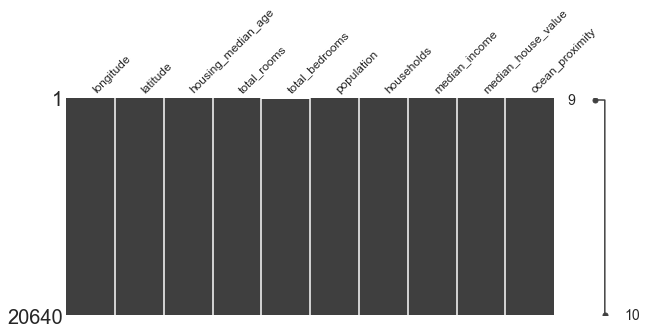

In [7]:
import missingno as msno
msno.matrix(housing_all_df.sample(len(housing_all_df)), figsize=(10, 4), width_ratios=(10, 1), fontsize=12)

When we looked at the top five rows, we can notice that the values in the `ocean_proximity` column are repetitive, which means that it is probably a categorical attribute. We can find out what categories exist and how many districts belong to each category by using the `value_counts()`

In [8]:
# check the categorical attribute's distribution
housing_all_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

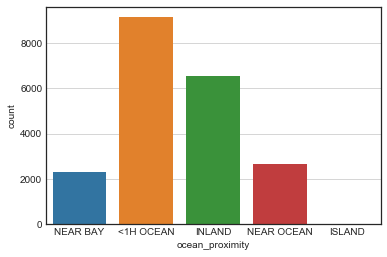

In [9]:
sns.countplot(x="ocean_proximity", data=housing_all_df)
plt.grid(which='major', axis='y');

Let's look at the other fields. The `describe()` method shows a summary of the numerical attributes

In [10]:
housing_all_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The `count`, `mean`, `min`, and `max` rows are self-explanatory. Note that the null values are ignored (so, for example, `count` of `total_bedrooms` is 20,433, not 20,640). The std row shows the standard deviation (which measures how dispersed the values are). The 25%, 50%, and 75% rows show the corresponding `percentiles`: a percentile indicates the value below which a given percentage of observations in a group of observations falls. For example, 25% of the districts have a `housing_median_age` lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25<sup>th</sup> percentile (or 1<sup>st</sup> quartile), the median, and the 75<sup>th</sup> percentile (or 3<sup>rd</sup> quartile).

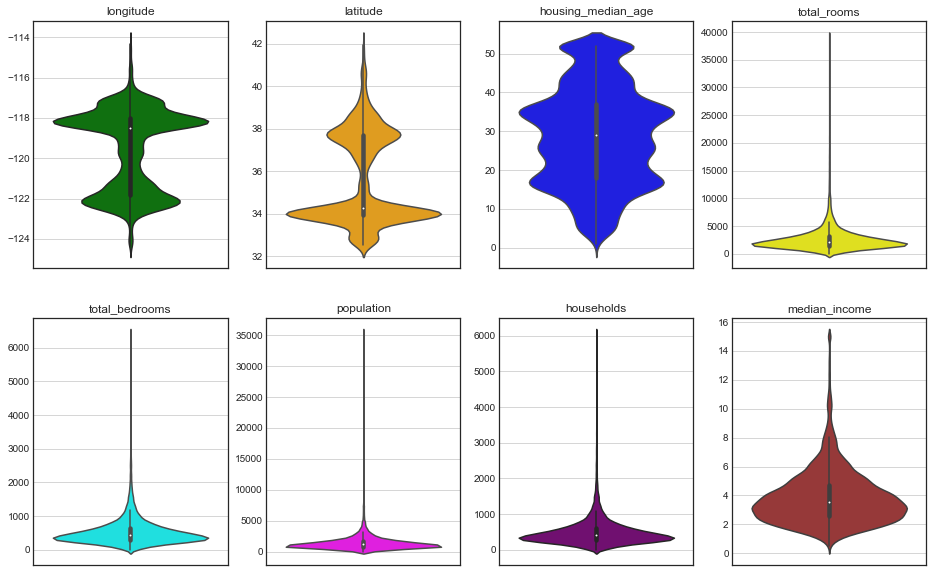

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False, sharey=False, figsize=(16, 10))
sns.violinplot(y=['longitude'], data=housing_all_df, color='green', ax=axes[0, 0])
axes[0, 0].set_title('longitude')
axes[0, 0].grid(which='major', axis='y')
sns.violinplot(y=['latitude'], data=housing_all_df, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('latitude')
axes[0, 1].grid(which='major', axis='y')
sns.violinplot(y=['housing_median_age'], data=housing_all_df, color='blue', ax=axes[0, 2])
axes[0, 2].set_title('housing_median_age')
axes[0, 2].grid(which='major', axis='y')
sns.violinplot(y=['total_rooms'], data=housing_all_df, color='yellow', ax=axes[0, 3])
axes[0, 3].set_title('total_rooms')
axes[0, 3].grid(which='major', axis='y')
sns.violinplot(y=['total_bedrooms'], data=housing_all_df, color='cyan', ax=axes[1, 0])
axes[1, 0].set_title('total_bedrooms')
axes[1, 0].grid(which='major', axis='y')
sns.violinplot(y=['population'], data=housing_all_df, color='magenta', ax=axes[1, 1])
axes[1, 1].set_title('population')
axes[1, 1].grid(which='major', axis='y')
sns.violinplot(y=['households'], data=housing_all_df, color='purple', ax=axes[1, 2])
axes[1, 2].set_title('households')
axes[1, 2].grid(which='major', axis='y')
sns.violinplot(y=['median_income'], data=housing_all_df, color='brown', ax=axes[1, 3])
axes[1, 3].set_title('median_income')
axes[1, 3].grid(which='major', axis='y');

Another quick way to get a feel of the type of data we are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). We can either plot this one attribute at a time, or we can call the *hist()* method on the whole dataset, and it will plot a histogram for each numerical attribute. For example, we can see that slightly over 1000 districts have a median_house_value equal to about $500,000.

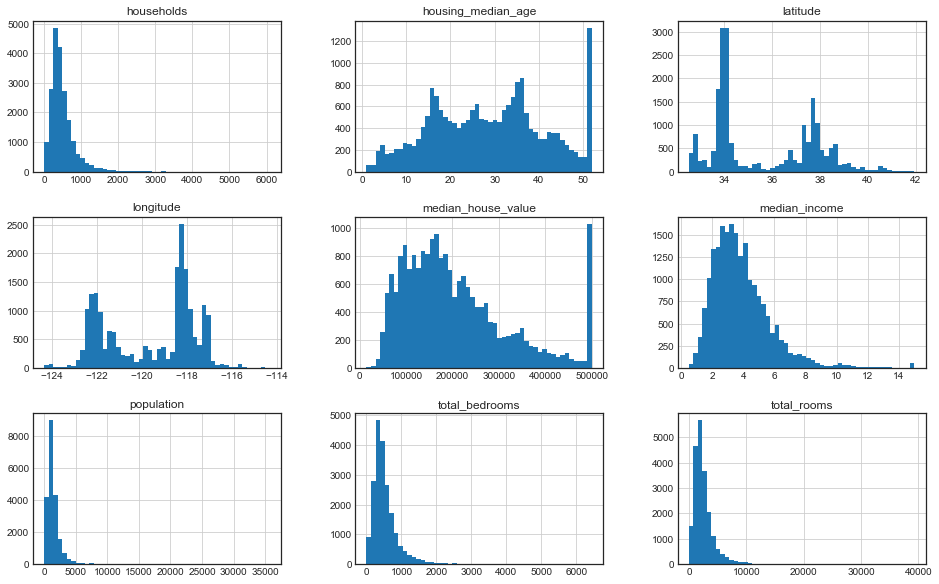

In [12]:
housing_all_df.hist(bins=50, figsize=(16, 10));

For example, we can see that slightly over 1000 districts have a `median_house_value` equal to about \$500,000.

Notice a few things in these histograms: 

1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, we are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but we should try to understand how the data was computed.

2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is our target attribute (our labels). Our Machine Learning algorithms may learn that prices never go beyond that limit. We need to check with our client team (the team that will use our system's output) to see if this is a problem or not. If they tell us that they need precise predictions even beyond $500,000, then we have mainly two options:

    - a. Collect proper labels for the districts whose labels were capped.
    
    - b. Remove those districts from the training set (and also from the test set, since our system should not be evaluated poorly if it predicts values beyond \$500,000). 
    
3. These attributes have very different scales. We will discuss this later when we explore feature scaling. 

4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### 3. Create a Test Set

It may sound strange to voluntarily set aside part of the data at this stage. After all, we have only taken a quick glance at the data, and surely we should learn a whole lot more about it before we decide what algorithms to use, right? This is true, but our brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if we look at the test set, we may stumble upon some seemingly interesting pattern in the test data that leads us to select a particular kind of Machine Learning model. When we estimate the generalization error using the test set, our estimate will be too optimistic and we will launch a system that will not perform as well as expected. This is called **`data snooping`** bias. Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_all_df, test_size=0.2, random_state=random_state)

In [14]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


So far we have considered purely random sampling methods. This is generally fine if our dataset is large enough (especially relative to the number of attributes), but if it is not, we run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don't just pick 1,000 people randomly in a phone booth. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called **`stratified sampling`**: the population is divided into homogeneous subgroups called `strata`, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased. Suppose we chatted with experts who told us that the median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, we first need to create an income category attribute. Let's look at the median income histogram more closely.

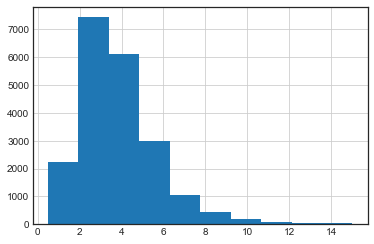

In [15]:
housing_all_df['median_income'].hist();

Most median income values are clustered around 2– 5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in our dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that we should not have too many strata, and each stratum should be large enough. The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using `ceil` (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [16]:
# what is the minimum median_income
housing_all_df['median_income'].min()

0.49990000000000001

In [17]:
# what is the maximum median_income
housing_all_df['median_income'].max()

15.0001

In [18]:
# Divide by 1.5 to limit the number of income categories
housing_all_df['income_cat'] = np.ceil(housing_all_df['median_income'] / 1.5)

In [19]:
housing_all_df['income_cat'].sample(5, random_state=random_state)

20046    2.0
3024     2.0
15663    3.0
20484    4.0
9814     3.0
Name: income_cat, dtype: float64

In [20]:
# Label those above 5 as 5
housing_all_df['income_cat'].where(housing_all_df['income_cat'] < 5, 5.0, inplace=True)

In [21]:
housing_all_df["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

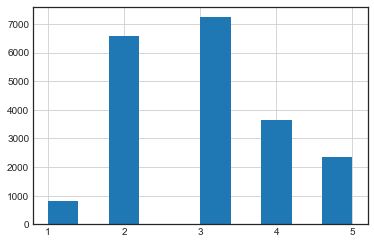

In [22]:
ax = housing_all_df["income_cat"].hist()
ax.set_xticks(range(1,6));

Now we are ready to do stratified sampling based on the income category. For this we can use Scikit-Learn's `train_test_split` with `stratify` parameter.

In [23]:
# stratified sampling
strat_train_set, strat_test_set = train_test_split(housing_all_df, test_size=0.2, 
                                                   stratify = housing_all_df['income_cat'], random_state=random_state)

Let's see if this worked as expected. We can start by looking at the income category proportions in the full housing dataset:

In [24]:
housing_all_df["income_cat"].value_counts() / len(housing_all_df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

With similar code we can measure the income category proportions in the test set.

In [25]:
def income_cat_proportions(data):
    return data.value_counts() / len(data)

In [26]:
# non-stratified sampling
train_set, test_set = train_test_split(housing_all_df, test_size=0.2, random_state=random_state)

In [27]:
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing_all_df['income_cat']),
    "Stratified" : income_cat_proportions(strat_test_set['income_cat']),
    "Random" : income_cat_proportions(test_set['income_cat'])
})

compare_props.sort_index(inplace=True)

compare_props['Rand. %error'] = 100 * abs(1 - compare_props['Random'] / compare_props['Overall'])
compare_props['Strat. %error'] = 100 * abs(1 - compare_props['Stratified'] / compare_props['Overall'])

In [28]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,0.243309
2.0,0.318847,0.324370,0.318798,1.732260,0.015195
3.0,0.350581,0.358527,0.350533,2.266446,0.013820
4.0,0.176308,0.167393,0.176357,5.056334,0.027480
5.0,0.114438,0.109496,0.114583,4.318374,0.127011


The table above compares the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling. As we can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

Now we should remove the income_cat attribute so the data is back to its original state:

In [29]:
strat_train_set = strat_train_set.drop("income_cat", axis=1)
strat_test_set = strat_test_set.drop("income_cat", axis=1)

### 4. Discover and Visualize the Data to Gain Insights

So far we have only taken a quick glance at the data to get a general understanding of the kind of data we are manipulating. Now the goal is to go a little bit more in depth. First, make sure we have put the test set aside and we are only exploring the training set. Also, if the training set is very large, we may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so we can just work directly on the full set. Let's create a copy so we can play with it without harming the training set:

In [30]:
housing_train = strat_train_set.copy()

#### 4.1 Visualizing Geographical Data 

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

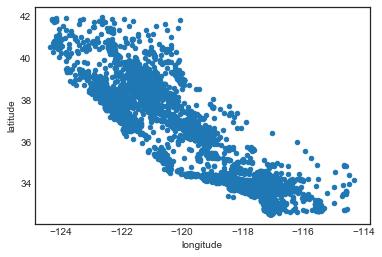

In [31]:
# bad visualization plot
housing_train.plot(kind='scatter', x='longitude', y='latitude');

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points.

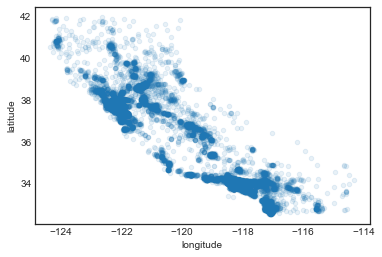

In [32]:
# better visualization plot
housing_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1);

Now that's much better: we can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno. More generally, our brains are very good at spotting patterns on pictures, but we may need to play around with visualization parameters to make the patterns stand out. Now let's look at the housing prices. The radius of each circle represents the district's population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

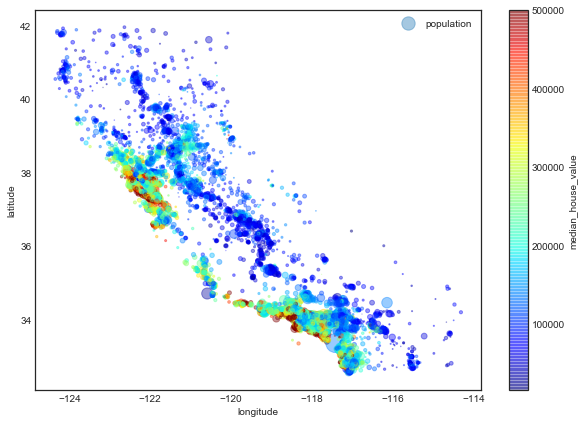

In [33]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_train["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), figsize=(10,7), colorbar=True,
    sharex=False)
plt.legend();

This image tells us that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as we probably knew already. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

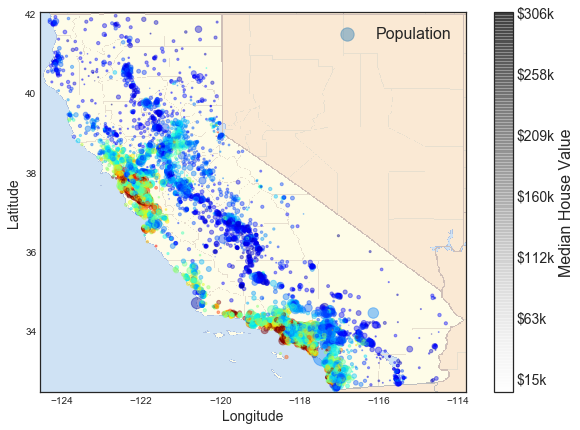

In [34]:
import matplotlib.image as mpimg
california_img = mpimg.imread('images/california.png')
ax = housing_train.plot(kind="scatter", x="longitude", y="latitude",
                       s=housing_train['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"), figsize=(10,7),
                       colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing_train["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show();

#### 4.2 Looking for Correlations 
Since the dataset is not too large, we can easily compute the standard correlation coefficient (also called Pearson's r) between every pair of attributes using the `corr()` method:

In [35]:
corr_matrix = housing_train.corr()

Now let's look at how much each attribute correlates with the median house value:

In [36]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from -1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; we can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to zero mean that there is no linear correlation.

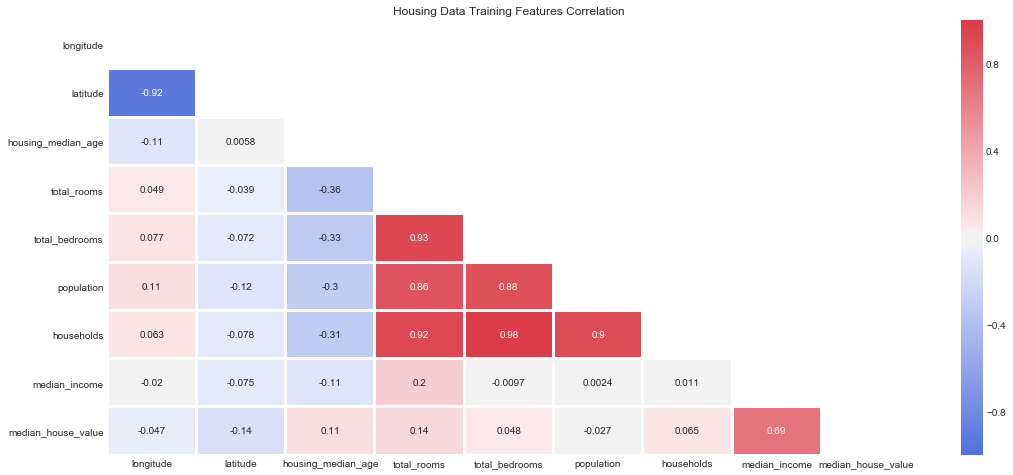

In [37]:
# Compute the correlation matrix
corr_matrix = housing_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 8))
plt.title('Housing Data Training Features Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, square=False, vmin=-1.0, vmax=1.0, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=2);
#sns.heatmap(corrMatt, mask=mask, vmax=1.2, square=True, annot=True, fmt='.2g', ax=ax);

Another way to check for correlation between attributes is to use Pandas' scatter_matrix function, which plots every numerical attribute against every other numerical attribute. Since there are now 10 numerical attributes, you would get 10<sup>2</sup> = 100 plots, which would not fit on a page, so let's just focus on a few promising attributes that seem most correlated with the median housing value.

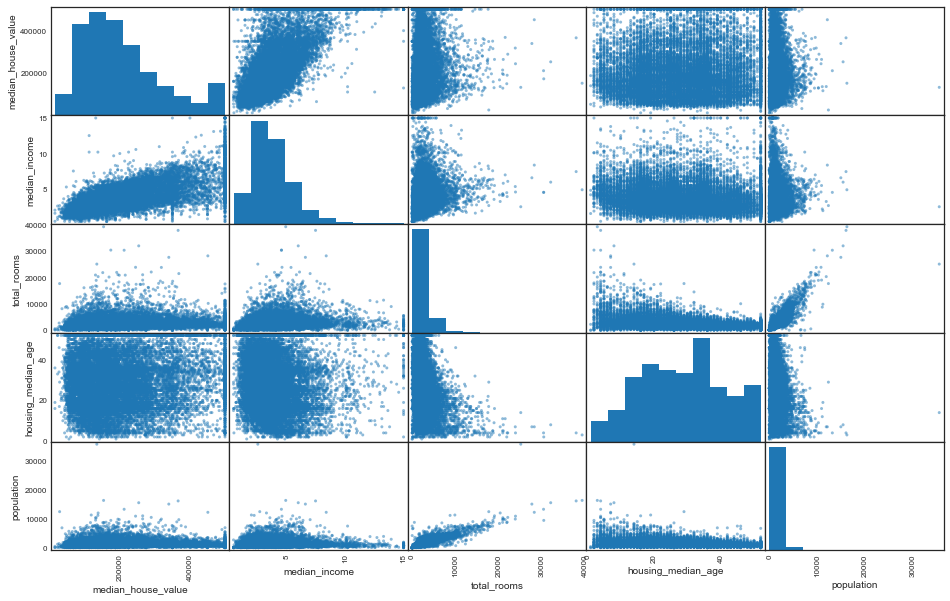

In [38]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'population']
scatter_matrix(housing_train[attributes], diagonal='hist', figsize=(16,10));

The main diagonal (top left to bottom right) would be full of straight lines if Pandas plotted each variable against itself, which would not be very useful. So instead Pandas displays a histogram of each attribute (other options are available; see Pandas' documentation for more details). 

The most promising attribute to predict the median house value is the median income, so let's zoom in on their correlation scatterplot.

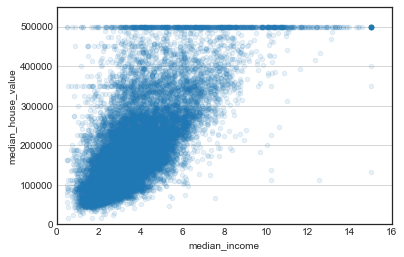

In [39]:
housing_train.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.grid(which='major', axis='y');

This plot reveals a few things. First, the correlation is indeed very strong; we can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at \$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \$450,000, another around \$350,000, perhaps one around \$280,000, and a few more below that. We may want to try removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

### 5. Experimenting with Attribute Combinations 

The previous sections gave us an idea of a few ways we can explore the data and gain insights. We identified a few data quirks that we may want to clean up before feeding the data to a Machine Learning algorithm, and we found interesting correlations between attributes, in particular with the target attribute. We also noticed that some attributes have a tail-heavy distribution, so we may want to transform them (e.g., by computing their logarithm). Of course, our mileage will vary considerably with each project, but the general ideas are similar. One last thing we may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if we don't know how many households there are. What we really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: we probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let's create these new attributes:

In [40]:
housing_train['rooms_per_household'] = housing_train['total_rooms'] / housing_train['households']
housing_train['bedrooms_per_room'] = housing_train['total_bedrooms'] / housing_train['total_rooms']
housing_train['population_per_household'] = housing_train['population'] / housing_train['households']

And now let's look at the correlation matrix again:

In [41]:
corr_matrix = housing_train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Not bad! The new `rooms_per_household` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom / room ratio tend to be more cheaper. The number of rooms per household is also more informative than the total number of rooms in a district - obviously the larger the houses, the more expensive they are. This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help us get a first reasonably good prototype. But this is an iterative process: once we get a prototype up and running, we can analyze its output to gain more insights and come back to this exploration step.

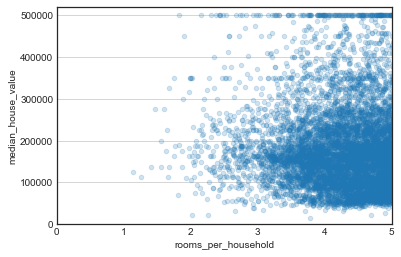

In [42]:
housing_train.plot(kind='scatter', x='rooms_per_household', y='median_house_value', alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.grid(which='major', axis='y');

In [43]:
housing_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


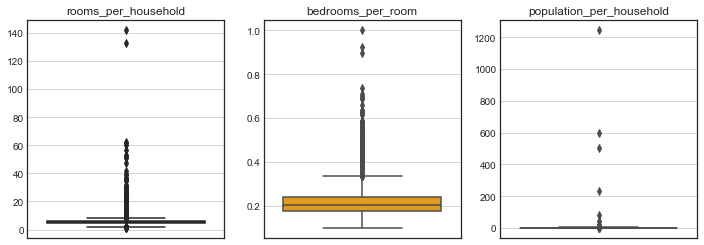

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(12, 4))
sns.boxplot(y=['rooms_per_household'], data=housing_train, color='green', ax=axes[0])
axes[0].set_title('rooms_per_household')
axes[0].grid(which='major', axis='y')
sns.boxplot(y=['bedrooms_per_room'], data=housing_train, color='orange', ax=axes[1])
axes[1].set_title('bedrooms_per_room')
axes[1].grid(which='major', axis='y')
sns.boxplot(y=['population_per_household'], data=housing_train, color='blue', ax=axes[2])
axes[2].set_title('population_per_household')
axes[2].grid(which='major', axis='y');

### 6. Prepare the Data for Machine Learning Algorithms 

It's time to prepare the data for our Machine Learning algorithms. Instead of just doing this manually, we should write functions to do that, for several good reasons: 

- This will allow us to reproduce these transformations easily on any dataset (e.g., the next time we get a fresh dataset). 

- We will gradually build a library of transformation functions that we can reuse in future projects. 

- We can use these functions in our live system to transform the new data before feeding it to our algorithms. 

- This will make it possible for us to easily try various transformations and see which combination of transformations works best. 

But first let's revert to a clean training set (by copying strat_train_set once again), and let's separate the predictors and the labels since we don't necessarily want to apply the same transformations to the predictors and the target values (note that `drop()` creates a copy of the data and does not affect strat_train_set :-)

In [45]:
housing_train = strat_train_set.drop('median_house_value', axis=1) # drop labels for training set
housing_train_labels = strat_train_set['median_house_value'].copy()

#### 6.1 Data Cleaning - Handling Missing Values

Most Machine Learning algorithms cannot work with missing features, so let's create a few functions to take care of them. We noticed earlier that the `total_bedrooms` attribute has some missing values, so let's fix this. We have three options: 

- Get rid of the corresponding districts. 
- Get rid of the whole attribute. 
- Set the values to some value (zero, the mean, the median, etc.). 

We can accomplish these easily using DataFrame's `dropna()`, `drop()`, and `fillna()` methods:

In [46]:
housing_train.shape

(16512, 9)

In [47]:
sample_incomplete_rows = housing_train[housing_train.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


**Option 1:** Drop all the rows where the total_bedrooms attribute have null value

In [48]:
# option 1
sample_incomplete_rows.dropna(subset=['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


**Option 2:** Remove the entire total_bedrooms column.

In [49]:
# option 2
sample_incomplete_rows.drop('total_bedrooms', axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


**Option 3:** Compute the median value on the training set, and use it to fill the missing values in the training set. But also we should not forget to save the median value that we have computed. We will need it later to replace missing values in the test set when we want to evaluate our system, and also once the system goes live to replace missing values in new data.

In [50]:
# option 3
median = housing_train['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


All the cells where the total_bedrooms attribute had null value has been replaced by 433.0

**Using Scikit-Learn's Imputer**

Scikit-Learn provides a handy class to take care of missing values: *Imputer*. First, we need to create an *Imputer* instance, specifying that we want to replace each attribute's missing values with the median of that attribute:

In [51]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute *ocean_proximity*:

In [52]:
housing_train_numeric = housing_train.drop('ocean_proximity', axis=1)
# alternatively: housing_train_numeric = housing_train.select_dtypes(include=[np.number])

Now we can fit the *imputer* instance to the training data using the *fit()* method:

In [53]:
imputer.fit(housing_train_numeric)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The `imputer` has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. Only the `total_bedrooms` attribute had missing values, but we cannot be sure that there won't be any missing values in new data after the system goes live, so it is safer to apply the `imputer` to all the numerical attributes:

In [54]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [55]:
housing_train_numeric.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Transform the training set: Now we can use this "trained" imputer to transform the training set by replacing missing values by the learned medians:

In [56]:
imputer.strategy

'median'

In [57]:
imputer.transform(housing_train_numeric)

array([[ -121.89  ,    37.29  ,    38.    , ...,   710.    ,   339.    ,
            2.7042],
       [ -121.93  ,    37.05  ,    14.    , ...,   306.    ,   113.    ,
            6.4214],
       [ -117.2   ,    32.77  ,    31.    , ...,   936.    ,   462.    ,
            2.8621],
       ..., 
       [ -116.4   ,    34.09  ,     9.    , ...,  2098.    ,   765.    ,
            3.2723],
       [ -118.01  ,    33.82  ,    31.    , ...,  1356.    ,   356.    ,
            4.0625],
       [ -122.45  ,    37.77  ,    52.    , ...,  1269.    ,   639.    ,
            3.575 ]])

The result is a plain Numpy array containing the transformed features. If we want to put it back into a Pandas DataFrame, it's simple:

In [58]:
# Creatting a pandas DateFrame with the imputed training data
housing_train_imputed = pd.DataFrame(imputer.transform(housing_train_numeric), columns=housing_train_numeric.columns, index = housing_train_numeric.index)
housing_train_imputed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Let's compare with sample_incomplete_rows where we changed the `total_bedrooms` column manually

In [59]:
housing_train_imputed.loc[sample_incomplete_rows.index]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


#### 6.2 Handling Text and Categorical Attributes

Earlier we left out the categorical attribute `ocean_proximity` because it is a text attribute so we cannot compute its median. Most Machine Learning algorithms prefer to work with numbers anyway, so let's convert these text labels to numbers. 

**Using panda's factorize() and sklearn's OneHotEncoder**

We can use Pandas' factorize() method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

In [60]:
housing_train['ocean_proximity'].head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [61]:
housing_cat_encoded, housing_categories = housing_train['ocean_proximity'].factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

This is better: now we can use this numerical data in any ML algorithm. We can look at the mapping that this encoder has learned using the `housing_categories` ("< 1H OCEAN" is mapped to 0, "NEAR OCEAN" is mapped to 1, "INLAND" is mapped to 2, etc.):

In [62]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. Obviously this is not the case (for example, categories 0 and 3 are more similar than categories 0 and 2). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "< 1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is "INLAND" (and 0 otherwise), and so on. This is called `one-hot encoding`, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). Scikit-Learn provides a `OneHotEncoder` encoder to convert integer categorical values into one-hot vectors. Let's encode the categories as one-hot vectors. Note that `fit_transform()` expects a 2D array, but `housing_cat_encoded` is a 1D array, so we need to reshape it:

In [63]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_one_hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_one_hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when we have categorical attributes with thousands of categories. After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for one 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. We can use it mostly like a normal 2D array, but if we really want to convert it to a (dense) NumPy array, just call the `toarray()` method:

In [64]:
housing_cat_one_hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

**Using pandas get_dmmies() method:**

A better way to apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the `get_dummies` method of the pandas dataframe:

In [65]:
housing_cat_one_hot = pd.get_dummies(housing_train['ocean_proximity'], prefix='ocean_proximity', sparse=False)
housing_cat_one_hot.head(5)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0


In [66]:
housing_cat_one_hot.head(10).as_matrix()

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

But the drawback of this method is that it can be used only in the Data Exploratory phase but we cannot as a step in Machine Learning pipeline because it is not a Transformer. We will see advanced example of this in the later section.

**Using scikit-learn's LabelBinarizer**

Scikit-Learn provides a LabelBinarizer class to take care of Binarizing the labels in a one-vs-all fashion

In [67]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit_transform(housing_train['ocean_proximity'].values)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [68]:
lb.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], 
      dtype='<U10')

The above conversion by LabelBinarizer may seem to exactly what we need but this approach is incorrect. The LabelBinarizer class was designed to preprocess labels, not input features. The example below would make that clear.

Let us say that we have a input feature 'Sex' in the dataset and it takes two values "MALE" & "FEMALE". If we run LabelBinarizer on this input feature then the categories will be encoded right but we would get only one column instead of two columns as desired in one-hot encoding.

In [69]:
lb = LabelBinarizer()
lb.fit_transform(["MALE", "FEMALE", "MALE", "FEMALE", "FEMALE", "MALE"])

lb.classes_

array(['FEMALE', 'MALE'], 
      dtype='<U6')

The LabelBinarizer will also fail in the case if we pass more than one input feature. The LabelBinarizer is designed to work with only one feature i.e. the label.

**Creating a Custom Categorical One-Hot Encoder**

A better solution is to use Scikit-Learn's upcoming CategoricalEncoder class: it will soon be added to Scikit-Learn, and in the meantime we can develop our own Custom One-Hot Encoder using both LabelEncoder, OneHotEncoder.

Let's simulate a situtation where we have more than one categorical input features in our dataset. We create a new categorical column called "is_inland" to signify whether the "ocean_proximity" is "INLAND" or not.

In [70]:
housing_train['is_inland'] = 'YES'
housing_train['is_inland'] = housing_train['is_inland'].where(housing_train['ocean_proximity'] == 'INLAND', other='NO')

In [71]:
housing_train['is_inland'].value_counts()

NO     11249
YES     5263
Name: is_inland, dtype: int64

In [72]:
housing_train[['is_inland', 'ocean_proximity']].values.shape

(16512, 2)

In [73]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import check_array
X = check_array(housing_train[['is_inland', 'ocean_proximity']].values, dtype=np.object, accept_sparse='csc', copy=True)
n_samples, n_features = X.shape

In [74]:
n_samples, n_features

(16512, 2)

Create a set of LabelEncoder & OneHotEncoder for each feature.

In [75]:
label_encoders_ = [LabelEncoder() for _ in range(n_features)]
one_hot_encoders_ = [OneHotEncoder(dtype=np.int, sparse=False) for _ in range(n_features)]

In [76]:
label_encoders_

[LabelEncoder(), LabelEncoder()]

In [77]:
one_hot_encoders_

[OneHotEncoder(categorical_features='all', dtype=<class 'int'>,
        handle_unknown='error', n_values='auto', sparse=False),
 OneHotEncoder(categorical_features='all', dtype=<class 'int'>,
        handle_unknown='error', n_values='auto', sparse=False)]

Encode the first feature into integers using LabelEncoder and then use OneHotEncoder to convert the encoded integers into one-hot encoded array

In [78]:
cat_encoded = label_encoders_[0].fit_transform(X[:, 0])
cat_encoded

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [79]:
cat_one_hot = one_hot_encoders_[0].fit_transform(cat_encoded.reshape(-1, 1))
cat_one_hot

array([[1, 0],
       [1, 0],
       [1, 0],
       ..., 
       [0, 1],
       [1, 0],
       [1, 0]], dtype=int32)

Extend the above principle to all the features now in a loop and append the one-hot vectors for all the features in a numpy array columnwise

In [80]:
res = np.c_[one_hot_encoders_[0].fit_transform(label_encoders_[0].fit_transform(X[:, 0]).reshape(-1, 1))]
for i in range(1, n_features):
    res = np.c_[res, one_hot_encoders_[i].fit_transform(label_encoders_[i].fit_transform(X[:, i]).reshape(-1, 1))]
res

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [81]:
res.shape

(16512, 7)

Looks Good! We can now wrap this entire logic into our custom categorical encoder **MultiCategoricalOneHotEncoder** and override the fit and transform method appropriately. 

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import sparse

class MultiCategoricalOneHotEncoder(BaseEstimator, TransformerMixin):
    '''
    A composite transformer made of LabelEncoder and OneHotEncoder
    '''
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        
        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]
        self._one_hot_encoders_ = [OneHotEncoder(dtype=np.int, sparse=False) for _ in range(n_features)]
        
        # It is important to both fit & tranform the LabelEncoder and only fit the OneHotEncoder here
        for i in range(n_features):
            self._label_encoders_[i].fit(X[:, i])
            # The OneHotEncoder expects a 2D array as input, so we need to reshape the input to a 2D array
            self._one_hot_encoders_[i].fit(self._label_encoders_[i].transform(X[:, i]).reshape(-1, 1))
        
        self.categories_ = [le.classes_ for le in self._label_encoders_]
        
        return self

    def transform(self, X):
        
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        
        cat_encoded = self._label_encoders_[0].transform(X[:, 0])
        cat_one_hot = self._one_hot_encoders_[0].transform(cat_encoded.reshape(-1, 1))
        
        res = np.c_[cat_one_hot]
        
        for i in range(1, n_features):
            cat_encoded = self._label_encoders_[i].transform(X[:, i])
            # The OneHotEncoder expects a 2D array as input, so we need to reshape the input to a 2D array
            cat_one_hot = self._one_hot_encoders_[i].transform(cat_encoded.reshape(-1, 1))
            res = np.c_[res, cat_one_hot]
            
        return res

Let's test our MultiCategoricalOneHotEncoder:

In [83]:
MultiCategoricalOneHotEncoder().fit_transform(housing_train[['ocean_proximity']])

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]], dtype=int32)

In [84]:
MultiCategoricalOneHotEncoder().fit_transform(housing_train[['is_inland']])

array([[1, 0],
       [1, 0],
       [1, 0],
       ..., 
       [0, 1],
       [1, 0],
       [1, 0]], dtype=int32)

In [85]:
MultiCategoricalOneHotEncoder().fit_transform(housing_train[['is_inland', 'ocean_proximity']])

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int32)

Let's test our MultiCategoricalOneHotEncoder using fit and transform on a sample test set of data.

In [86]:
# first train the custom encoder on the entire training set
cat_encoder = MultiCategoricalOneHotEncoder()
housing_cat_one_hot = cat_encoder.fit_transform(housing_train[['is_inland', 'ocean_proximity']])
housing_cat_one_hot

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [87]:
cat_encoder.categories_

[array(['NO', 'YES'], dtype=object),
 array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

In [88]:
housing_cat_one_hot.shape

(16512, 7)

In [89]:
# pick a random sample test set (Not necessarily they will have all the five categories of ocean_proximity)
some_data = housing_train.iloc[:5]
some_data[['is_inland', 'ocean_proximity']]

,is_inland,ocean_proximity
17606,NO,<1H OCEAN
18632,NO,<1H OCEAN
14650,NO,NEAR OCEAN
3230,YES,INLAND
3555,NO,<1H OCEAN


In [90]:
# verify the encoded output (although the sample test may not have all the categories of ocean_proximity 
# it should still one hot encode with all categories)
some_data_cat_one_hot = cat_encoder.transform(some_data[['is_inland', 'ocean_proximity']])
some_data_cat_one_hot

array([[1, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0]], dtype=int32)

In [91]:
some_data_cat_one_hot.shape

(5, 7)

In [92]:
housing_train = housing_train.drop('is_inland', axis=1)

#### Custom Transformers

Although Scikit-Learn provides many useful transformers, we will need to write our own for tasks such as custom cleanup operations or combining specific attributes. We will want our transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all we need is to create a class and implement three methods: `fit()` (returning `self`), `transform()`, and `fit_transform()`. We can get the last one for free by simply adding `TransformerMixin` as a base class. Also, if we add `BaseEstimator` as a base class (and avoid `*args` and `**kargs` in our constructor) we will get two extra methods (`get_params()` and `set_params()`) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            self.extra_attribs_ = ["rooms_per_household", "population_per_household",  "bedrooms_per_room"]
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            self.extra_attribs_ = ["rooms_per_household", "population_per_household"]
            return np.c_[X, rooms_per_household, population_per_household]

In [94]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_train_extra_attribs = attr_adder.transform(housing_train.values)

In [95]:
housing_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [96]:
housing_train_extra_attribs = pd.DataFrame(housing_train_extra_attribs, columns=list(housing_train.columns)+['rooms_per_household','population_per_household'])
housing_train_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [97]:
housing_train_extra_attribs.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'population_per_household'],
      dtype='object')

In [98]:
attr_adder.extra_attribs_

['rooms_per_household', 'population_per_household']

In this example the transformer has one hyperparameter, `add_bedrooms_per_room`, set to `True` by default (it is often helpful to provide sensible defaults). This hyperparameter will allow us to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, we can add a hyperparameter to get any data preparation step that we are not 100% sure about. The more we automate these data preparation steps, the more combinations we can automatically try out, making it much more likely that we will find a great combination (and saving us a lot of time). 

#### 6.3 Feature Scaling 
One of the most important transformations we need to apply to our data is `feature scaling`. With few exceptions, Machine Learning algorithms don't perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: `min-max scaling` and `standardization`. Min-max scaling (many people call this `normalization`) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets us change the range if we don't want 0 - 1 for some reason. 

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0 - 15 down to 0 - 0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called `StandardScaler` for standardization.

**Warning:** As with all the transformations, **it is important to fit the scalers to the training data only, not to the full dataset (including the test set)**. Only then can we use them to transform the training set and the test set (and new data).

#### 6.4 Transformation Pipelines 

As we can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the `Pipeline` class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes: 

In [99]:
housing_train_numeric = housing_train.drop('ocean_proximity', axis=1)

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

The `Pipeline` constructor takes a list of name/ estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform()` method). The names can be anything we like. When we call the pipeline’s `fit()` method, it calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the `fit()` method. The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a `StandardScaler`, which is a transformer, so the pipeline has a `transform()` method that applies all the transforms to the data in sequence (it also has a `fit_transform` method that we could also use instead of calling `fit()` and then `transform()`).

In [101]:
# Call the fit and transform methods in sequence for the pipeline
num_pipeline.fit(housing_train_numeric)
housing_train_numeric_transf = num_pipeline.transform(housing_train_numeric)
housing_train_numeric_transf

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [102]:
# Call the fit_transform method of the pipeline 
housing_train_numeric_transf = num_pipeline.fit_transform(housing_train_numeric)
housing_train_numeric_transf

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

We now have a pipeline for numerical values, and we also need to apply the `MultiCategoricalOneHotEncoder` on the categorical values. We can also have each subpipeline start with a selector transformer: it simply transforms the data by selecting the desired attributes (numerical or categorical), dropping the rest, and converting the resulting DataFrame to a NumPy array. There is nothing in Scikit-Learn to handle Pandas DataFrames, so we need to write a simple custom transformer for this task:

In [103]:
from sklearn.base import BaseEstimator, TransformerMixin

# create a class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [104]:
numeric_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
categorical_attribs = ['ocean_proximity']

numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_attribs)),
    ('categorial_one_hot_encoder', MultiCategoricalOneHotEncoder())
])

In [105]:
housing_train_numeric_transf = numeric_pipeline.fit_transform(housing_train)
housing_train_numeric_transf

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [106]:
housing_train_numeric_transf.shape

(16512, 11)

In [107]:
housing_train_cat_transf = categorical_pipeline.fit_transform(housing_train)
housing_train_cat_transf

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]], dtype=int32)

In [108]:
housing_train_cat_transf.shape

(16512, 5)

How can we join these transformations into a single pipeline? Scikit-Learn provides a `FeatureUnion` class for this. We give it a list of transformers (which can be entire transformer pipelines), and when its `transform()` method is called it runs each transformer’s transform() method in parallel, waits for their output, and then concatenates them and returns the result (and of course calling its `fit()` method calls all each transformer’s `fit()` method). A full pipeline handling both numerical and categorical attributes may look like this:

In [109]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('numeric_pipeline', numeric_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

In [110]:
housing_train_prepared = full_pipeline.fit_transform(housing_train)
housing_train_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [111]:
housing_train_prepared.shape

(16512, 16)

In [112]:
housing_train_prepared[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
        0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,  0.        ])

### 7. Select and Train a Model

At last! We framed the problem, we got the data and explored it, we sampled a training set and a test set, and we wrote transformation pipelines to clean up and prepare our data for Machine Learning algorithms automatically. We are now ready to select and train a Machine Learning model.

#### 7.1 Training and Evaluating on the Training Set

The good news is that thanks to all these previous steps, things are now going to be much simpler than we might think. Let’s first train a Linear Regression model:

In [113]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_train_prepared, housing_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Done! We now have a working Linear Regression model. Let’s try it out on a few instances from the training set:

In [114]:
housing_train.iloc[:5].shape

(5, 9)

In [115]:
housing_train.iloc[:5]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [116]:
some_data = housing_train.iloc[:5]
some_labels = housing_train_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [117]:
some_data_prepared.shape

(5, 16)

In [118]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [119]:
print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Compare against the actual values:

In [120]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate (e.g., the third and fourth predictions are off by significant amount!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error` function:

In [121]:
from sklearn.metrics import mean_squared_error

housing_train_predictions = lin_reg.predict(housing_train_prepared)
lin_mse = mean_squared_error(housing_train_labels, housing_train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [122]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_train_labels, housing_train_predictions)
lin_mae

49439.895990018973

Okay, this is better than nothing but clearly not a great score: most district's `median_housing_values` range between \$120,000 and \$265,000, so a typical prediction error of \$68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, so this rules out the last option. We could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does. Let’s train a `DecisionTreeRegressor`. This is a powerful model, capable of finding complex nonlinear relationships in the data:

In [123]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=random_state)
tree_reg.fit(housing_train_prepared, housing_train_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now that the model is trained, let’s evaluate it on the training set:

In [124]:
housing_train_predictions = tree_reg.predict(housing_train_prepared)
tree_mse = mean_squared_error(housing_train_labels, housing_train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [125]:
housing_train_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can we be sure? As we saw earlier, we don’t want to touch the test set until we are ready to launch a model we are confident about, so we need to use part of the training set for training, and part for model validation.

#### 7.2 Better Evaluation Using Cross-Validation 

One way to evaluate the Decision Tree model would be to use the `train_test_split` function to split the training set into a smaller training set and a validation set, then train our models against the smaller `training set` and evaluate them against the `validation set`. It’s a bit of work, but nothing too difficult and it would work fairly well. A great alternative is to use Scikit-Learn’s `cross-validation` feature. The following code performs `K-fold cross-validation`: it randomly splits the training set into 10 distinct subsets called `folds`, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [126]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_train_prepared, housing_train_labels, 
                         scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
tree_rmse_scores = np.sqrt(-scores)

**Warning:** Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes `-scores` before calculating the square root.

In [127]:
pd.Series(tree_rmse_scores).describe()

count       10.000000
mean     71379.074477
std       2591.295562
min      66828.468399
25%      70185.198058
50%      70943.514419
75%      72138.663111
max      75581.293199
dtype: float64

That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model. Let's try one last model now: the `RandomForestRegressor`. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called `Ensemble Learning`, and it is often a great way to push ML algorithms even further.

In [128]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, max_depth=None, min_samples_split=2, n_jobs=-1, random_state=random_state)
forest_reg.fit(housing_train_prepared, housing_train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [129]:
housing_train_predictions = forest_reg.predict(housing_train_prepared)
forest_mse = mean_squared_error(housing_train_labels, housing_train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [130]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_train_prepared, housing_train_labels,
                               scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
forest_rmse_scores = np.sqrt(-forest_scores)

In [131]:
pd.Series(forest_rmse_scores).describe()

count       10.000000
mean     52564.190252
std       2426.388036
min      48920.806455
25%      51058.706372
50%      52423.031088
75%      54136.991686
max      56488.556997
dtype: float64

Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

However, before we dive much deeper in Random Forests, we should try out many other models from various categories of Machine Learning algorithms (several Support Vector Machines with different kernels, possibly a neural network, etc.), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

In [132]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_train_prepared, housing_train_labels)
housing_train_predictions = svm_reg.predict(housing_train_prepared)
svm_mse = mean_squared_error(housing_train_labels, housing_train_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [133]:
svm_reg_scores = cross_val_score(svm_reg, housing_train_prepared, housing_train_labels, 
                         scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
svm_reg_rmse_scores = np.sqrt(-svm_reg_scores)

For the sake of completeness let's take the cross validation scores with Linear Regression as well.

In [134]:
from sklearn.linear_model import LinearRegression

lin_reg_scores = cross_val_score(lin_reg, housing_train_prepared, housing_train_labels, 
                         scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

In [135]:
pd.Series(lin_reg_rmse_scores).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

**Distribution of the training errors across algorithms**

In [136]:
rmse_scores_df = pd.DataFrame({'lin_reg_rmse_scores': lin_reg_rmse_scores, 
              'tree_rmse_scores': tree_rmse_scores, 
              'forest_rmse_scores':forest_rmse_scores, 
              'svm_reg_rmse_scores' : svm_reg_rmse_scores})

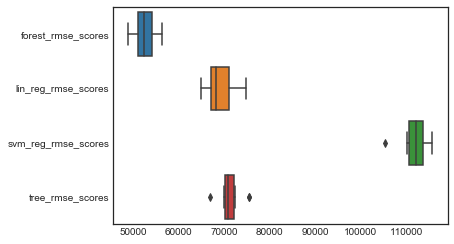

In [137]:
sns.boxplot(data=rmse_scores_df, orient='h');

### 8. Fine-Tune Our Model 

Let’s assume that we now have a shortlist of promising models. We now need to fine-tune them. Let’s look at a few ways we can do that. 

#### 8.1 Grid Search

One way to do that would be to fiddle with the hyperparameters manually, until we find a great combination of hyperparameter values. This would be very tedious work, and we may not have time to explore many combinations. 

Instead we should get Scikit-Learn’s `GridSearchCV` to search for us. All we need to do is tell it which hyperparameters we want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. For example, the following code searches for the best combination of hyperparameter values for the `RandomForestRegressor`:

In [138]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3x4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2x3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}    
]

forest_reg = RandomForestRegressor(random_state=random_state)
# train across 5 folds, that's a total of (12 + 6) * 5 = 90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(housing_train_prepared, housing_train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'max_features': [2, 3, 4], 'bootstrap': [False], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

This `param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of `n_estimators` and `max_features` hyperparameter values specified in the first dict, then try all 2 × 3 = 6 combinations of hyperparameter values in the second `dict`, but this time with the `bootstrap` hyperparameter set to `False` instead of `True` (which is the default value for this hyperparameter). All in all, the grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and it will train each model five times (since we are using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90 rounds of training! It may take quite a long time, but when it is done we can get the best combination of parameters like this:

In [139]:
# get the best parameters
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [140]:
# get the best score
np.sqrt(-grid_search.best_score_)

49694.851433344418

In [141]:
# get the best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

**Note** If `GridSearchCV` is initialized with `refit = True` (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.

Let's look at the score of each hyperparameter combination tested during the grid search:

In [142]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63647.854446 {'max_features': 2, 'n_estimators': 3}
55611.5015988 {'max_features': 2, 'n_estimators': 10}
53370.0640736 {'max_features': 2, 'n_estimators': 30}
60959.1388585 {'max_features': 4, 'n_estimators': 3}
52740.5841667 {'max_features': 4, 'n_estimators': 10}
50374.1421461 {'max_features': 4, 'n_estimators': 30}
58661.2866462 {'max_features': 6, 'n_estimators': 3}
52009.9739798 {'max_features': 6, 'n_estimators': 10}
50154.1177737 {'max_features': 6, 'n_estimators': 30}
57865.3616801 {'max_features': 8, 'n_estimators': 3}
51730.0755087 {'max_features': 8, 'n_estimators': 10}
49694.8514333 {'max_features': 8, 'n_estimators': 30}
62874.4073931 {'max_features': 2, 'bootstrap': False, 'n_estimators': 3}
54643.4998083 {'max_features': 2, 'bootstrap': False, 'n_estimators': 10}
59437.8922859 {'max_features': 3, 'bootstrap': False, 'n_estimators': 3}
52735.3582936 {'max_features': 3, 'bootstrap': False, 'n_estimators': 10}
57490.0168279 {'max_features': 4, 'bootstrap': False, 'n_estima

In this example, we obtain the best solution by setting the `max_features` hyperparameter to `8`, and the `n_estimators` hyperparameter to 30. The RMSE score for this combination is 49,694, which is slightly better than the score we got earlier using the default hyperparameter values (which was 52,634). Congratulations, we have successfully fine-tuned our best model!

**TIP:** Don't forget that we can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature we were not sure about (e.g., using the `add_bedrooms_per_room` hyperparameter of our `CombinedAttributesAdder` transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.

#### 8.2 Randomized Search

The grid search approach is fine when we are exploring relatively few combinations, like in the previous example, but when the hyperparameter `search space` is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
- If we let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach). 
- We have more control over the computing budget we want to allocate to hyperparameter search, simply by setting the number of iterations.

In [143]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs  = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)   
}

forest_reg = RandomForestRegressor(random_state=random_state)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, 
                                cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=random_state)
rnd_search.fit(housing_train_prepared, housing_train_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D383085EF0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D383085240>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [144]:
# get the best parameters
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [145]:
# get the best score
np.sqrt(-rnd_search.best_score_)

49147.152417245052

In [146]:
# get the best estimator
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=180, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [147]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50797.0573732 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50775.4633168 {'max_features': 3, 'n_estimators': 75}
50681.383925 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50473.0175142 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


#### 8.3 Ensemble Methods

Another way to fine-tune our system is to try to combine the models that perform best. The group (or "ensemble") will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors.

#### Analyze the Best Models and Their Errors 

We will often gain good insights on the problem by inspecting the best models. For example, the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions:

In [148]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.33442355e-02,   6.29090705e-02,   4.11437985e-02,
         1.46726854e-02,   1.41064835e-02,   1.48742809e-02,
         1.42575993e-02,   3.66158981e-01,   5.64191792e-02,
         1.08792957e-01,   5.33510773e-02,   1.03114883e-02,
         1.64780994e-01,   6.02803867e-05,   1.96041560e-03,
         2.85647464e-03])

In [149]:
_, numeric_pipeline = full_pipeline.transformer_list[0]

In [150]:
numeric_pipeline.named_steps['attribs_adder'].extra_attribs_

['rooms_per_household', 'population_per_household', 'bedrooms_per_room']

In [151]:
_, categorical_pipeline = full_pipeline.transformer_list[1]

In [152]:
categorical_pipeline.named_steps['categorial_one_hot_encoder'].categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

In [153]:
extra_attribs = numeric_pipeline.named_steps['attribs_adder'].extra_attribs_
# flatten out the nested list of categories stored in the MultiCategoricalOneHotEncoder
categorial_one_hot_attribs =[category 
                                 for categories in categorical_pipeline.named_steps['categorial_one_hot_encoder'].categories_ 
                                     for category in categories]
attributes = numeric_attribs + extra_attribs + categorial_one_hot_attribs
sorted(zip(attributes, feature_importances), reverse=True, key=lambda x: x[1])

[('median_income', 0.36615898061813418),
 ('INLAND', 0.16478099356159051),
 ('population_per_household', 0.10879295677551573),
 ('longitude', 0.073344235516012421),
 ('latitude', 0.062909070482620302),
 ('rooms_per_household', 0.056419179181954007),
 ('bedrooms_per_room', 0.053351077347675809),
 ('housing_median_age', 0.041143798478729635),
 ('population', 0.014874280890402767),
 ('total_rooms', 0.014672685420543237),
 ('households', 0.014257599323407807),
 ('total_bedrooms', 0.014106483453584102),
 ('<1H OCEAN', 0.010311488326303787),
 ('NEAR OCEAN', 0.0028564746373201579),
 ('NEAR BAY', 0.0019604155994780701),
 ('ISLAND', 6.0280386727365991e-05)]

In [154]:
feature_importances_df = pd.DataFrame({'Feature': attributes, 'Importance': feature_importances})
feature_importances_df.sort_values(by='Importance', axis=0, ascending=True, inplace=True)
feature_importances_df.reset_index(drop=True, inplace=True)
feature_importances_df

,Feature,Importance
0,ISLAND,0.000060
1,NEAR BAY,0.001960
2,NEAR OCEAN,0.002856
3,<1H OCEAN,0.010311
4,total_bedrooms,0.014106
5,households,0.014258
6,total_rooms,0.014673
7,population,0.014874
8,housing_median_age,0.041144
9,bedrooms_per_room,0.053351


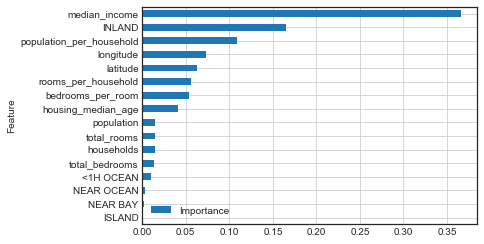

In [155]:
feature_importances_df.plot.barh(x='Feature', y='Importance')
plt.grid(which='both');

With this information, we may want to try dropping some of the less useful features (e.g., apparently only one `ocean_proximity` category is really useful, so we could try dropping the others). 

We should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).

### 9. Evaluate Our System on the Test Set 

After tweaking our models for a while, we eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from our test set, run our `full_pipeline` to transform the data (call `transform()`, *not* `fit_transform()`!), and evaluate the final model on the test set:

In [156]:
from sklearn.metrics import mean_squared_error

final_model = grid_search.best_estimator_

housing_test = strat_test_set.drop('median_house_value', axis=1)
housing_test_labels = strat_test_set['median_house_value'].copy()

housing_test_prepared = full_pipeline.transform(housing_test)
housing_test_predictions = final_model.predict(housing_test_prepared)

final_mse = mean_squared_error(housing_test_labels, housing_test_predictions)
final_rmse = np.sqrt(final_mse)

In [157]:
final_rmse

47766.003966433083

The performance will usually be slightly worse than what we measured using cross-validation if we did a lot of hyperparameter tuning (because our system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens we must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

**References:**

Book Chapter without which this notebook would not have been possible

+ [2<sup>nd</sup> chapter of Hands-On Machine Learning with Scikit-Learn & Tensorflow book by Aurélien Géron](https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb)